In [ ]:
#Importing Required Libraries
import gc
import h5py
import pickle
import numpy as np
from time import time
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras import layers,Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16,VGG19,MobileNet

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/My Drive/datasets/earth_data.zip" -d "./"

Archive:  /content/gdrive/My Drive/datasets/earth_data.zip
  inflating: ./earth_data.h5         


In [ ]:
!ls

earth_data.h5  gdrive  sample_data


In [ ]:
#Function to load data
def loadDataH5():
    with h5py.File('earth_data.h5','r') as hf:
        trainX = np.array(hf.get('trainX'))
        trainY = np.array(hf.get('trainY'))
        valX = np.array(hf.get('valX'))
        valY = np.array(hf.get('valY'))
        print (trainX.shape,trainY.shape)
        print (valX.shape,valY.shape)
    return trainX, trainY, valX, valY

In [ ]:
#Function to plot the accuracies and losses
def graph(History):
    X = History.epoch
    plt.figure()
    plt.plot(X, History.history["acc"], label="Training Accuracy", color = 'red',linewidth=1.5)
    plt.plot(X, History.history["loss"], label="Training Loss", color = 'green',linewidth=1.5)
    plt.plot(X, History.history["val_acc"], label="Validation Accuracy", color = 'black',linestyle = ":")
    plt.plot(X, History.history["val_loss"], label="Validation Loss", color = 'magenta', linestyle = ":")
    plt.title("Accuracy & Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy | Loss")
    plt.legend()
    plt.grid(False)
    plt.show()

In [ ]:
#Loading data and setting the parameters
epochs = 25
batch_size = 512
trainX, trainY, testX, testY = loadDataH5()
trainX, testX = trainX/255, testX/255

(19200, 64, 64, 3) (19200,)
(4800, 64, 64, 3) (4800,)


In [ ]:
#Image Augmentation - but it was later abandoned beacuse it was taking too long - not used in any code below
IDG = tf.keras.preprocessing.image.ImageDataGenerator(shear_range=0.3, zoom_range=0.3)#,rotation_range=60, horizontal_flip=True,vertical_flip=True, rescale = 1.3, brightness_range=[50,150],channel_shift_range = 1.25,height_shift_range=5,width_shift_range=5)
gen = IDG.flow(trainX, trainY,batch_size = batch_size)

In [ ]:
#Function to train and save VGG16 models
def train_vgg16(batch_size = 64, epochs = 50, gen = gen,trainX = trainX, trainY = trainY, testX = testX, testY = testY):
    print("\n\nTRAINING VGG16\n")
    start = time()
    vgg16_base_model = VGG16(input_shape = trainX.shape[1:],include_top = False,weights = 'imagenet')#VGG16
    x = layers.Flatten()(vgg16_base_model.output)#Flattening
    x = layers.Dense(256, activation='relu')(x)#Dense layer with 256 neurons
    x = layers.Dropout(0.5)(x)#0.5 Dropout
    x = layers.Dense(np.unique(trainY).shape[0], activation='softmax')(x)#Output - softmax layer
    vgg16_model = tf.keras.models.Model(vgg16_base_model.input, x)#Combining VGG to our above Network
    vgg16_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'sparse_categorical_crossentropy',metrics = ['acc'])#Compiling
    checkpoint = ModelCheckpoint("VGG16_chkpt.hdf5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)#Checkpoint
    early_stopping = EarlyStopping(patience = 10,restore_best_weights=True)#Early Stopping
    print(vgg16_model.summary())
    vgghist = vgg16_model.fit(trainX, trainY, batch_size = batch_size, validation_data = (testX, testY), epochs = epochs, callbacks=[checkpoint,early_stopping])#Training
    graph(vgghist)#Plot graph
    vgg16_model.save("vgg16_model.h5")#Saving model
    with open('vgghist.pkl', 'wb') as fh:
        pickle.dump(vgghist.history, fh)#Saving Training History
    print("Elapsed time:",time()-start,"secs")
    return vgg16_model

In [ ]:
def train_VGG19(batch_size = 64, epochs = 50, gen = gen,trainX = trainX, trainY = trainY, testX = testX, testY = testY):
    print("\n\nTRAINING VGG19\n")
    start = time()
    VGG19_base_model = VGG19(input_shape = trainX.shape[1:],include_top = False,weights = 'imagenet')#VGG19
    x = layers.Flatten()(VGG19_base_model.output)#Flattening
    x = layers.Dense(256, activation='relu')(x)#Dense layer with 256 N
    x = layers.Dropout(0.5)(x)# 0.5 Dropout
    x = layers.Dense(np.unique(trainY).shape[0], activation='softmax')(x) #Output - softmax layer
    VGG19_model = tf.keras.models.Model(VGG19_base_model.input, x) #Combining VGG19 to our Network
    VGG19_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'sparse_categorical_crossentropy',metrics = ['acc'])#Compiling
    checkpoint = ModelCheckpoint("VGG19_chkpt.hdf5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)#Chepoint
    early_stopping = EarlyStopping(patience = 10,restore_best_weights=True)#EarlyStopping
    print(VGG19_model.summary())
    VGG19hist = VGG19_model.fit(trainX, trainY, batch_size = batch_size, validation_data = (testX, testY), epochs = epochs, callbacks=[checkpoint,early_stopping])#training
    graph(VGG19hist)#plotting graph
    VGG19_model.save("VGG19_model.h5")#Saving model
    with open('VGG19hist.pkl', 'wb') as fh:
        pickle.dump(VGG19hist.history, fh)#Saving training history
    print("Elapsed time:",time()-start,"secs")
    return VGG19_model

In [ ]:
def train_MobileNet(batch_size = 64, epochs = 50, trainX = trainX, trainY = trainY, testX = testX, testY = testY):
    print("\n\nTRAINING MobileNet\n")
    start = time()
    MobileNet_base_model = MobileNet(input_shape = trainX.shape[1:],include_top = False,weights = 'imagenet')#MobileNet
    x = layers.Flatten()(MobileNet_base_model.output)#Flattening
    x = layers.Dense(256, activation='relu')(x)#Dense Layer with 256 Neurons
    x = layers.Dropout(0.5)(x)# 0.5 Dropout
    x = layers.Dense(np.unique(trainY).shape[0], activation='softmax')(x) #Output - Softmax layer
    MobileNet_model = tf.keras.models.Model(MobileNet_base_model.input, x) #Combining Mobilenet to our NN
    MobileNet_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'sparse_categorical_crossentropy',metrics = ['acc'])#Compiling
    checkpoint = ModelCheckpoint("MobileNet_chkpt.hdf5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)#Checkpoint
    early_stopping = EarlyStopping(patience = 10,restore_best_weights=True)#Early Stopping
    print(MobileNet_model.summary())
    MobileNethist = MobileNet_model.fit(trainX, trainY, batch_size = batch_size, validation_data = (testX, testY), epochs = epochs, callbacks=[checkpoint, early_stopping])#Training
    graph(MobileNethist)#Plotting graph
    MobileNet_model.save("MobileNet_model.h5")#Saving model
    with open('MobileNethist.pkl', 'wb') as fh:
        pickle.dump(MobileNethist.history, fh)#Saving training history
    print("Elapsed time:",time()-start,"secs")
    return MobileNet_model

In [ ]:
#Function to train VGG16,VGG19 and mobilenet sequentially
def train_all(batch_size = batch_size, epochs = epochs):
    start = time()
    K.clear_session()
    gc.collect()
    train_vgg16(batch_size = batch_size, epochs = epochs)
    K.clear_session()
    gc.collect()
    train_VGG19(batch_size = batch_size, epochs = epochs)
    K.clear_session()
    gc.collect()
    train_MobileNet(batch_size = batch_size, epochs = epochs)
    print("\n\nALL Models trained Successfully!")
    print("Total Elaspsed Training Time:",(time()-start)//60,"mins")




TRAINING VGG16

58892288/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
____________________________________________

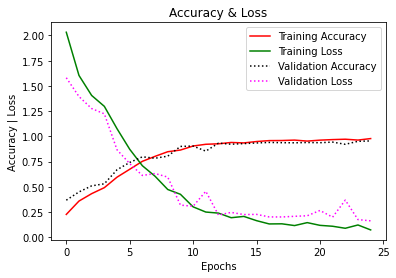

Elapsed time: 1102.4645366668701 secs


TRAINING VGG19

80142336/80134624 [==============================] - 8s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______

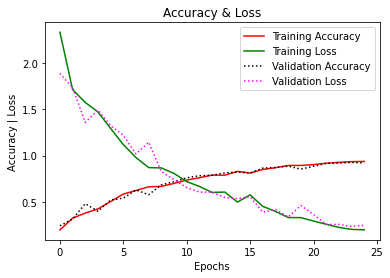

Elapsed time: 1225.5807712078094 secs


TRAINING MobileNet

17227776/17225924 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128       
__

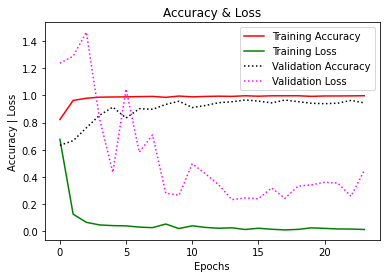

Elapsed time: 359.6448321342468 secs


ALL Models trained Successfully!
Total Elaspsed Training Time: 44.0 mins


In [ ]:
#Uncomment below and Call train_all only if required
train_all(batch_size = batch_size, epochs = epochs)

In [ ]:
#Function to load saved models and training history
def load_saved_models():
    with open('vgghist.pkl', 'rb') as fh:
        vgghist = pickle.load(fh)
    with open('VGG19hist.pkl', 'rb') as fh:
        VGG19hist = pickle.load(fh)
    with open('MobileNethist.pkl', 'rb') as fh:
        MobileNethist = pickle.load(fh)
    vgg16_model = load_model("vgg16_model.h5")
    VGG19_model = load_model("VGG19_model.h5")
    MobileNet_model = load_model("MobileNet_model.h5")
    return (vgg16_model,VGG19_model,MobileNet_model),(vgghist,VGG19hist,MobileNethist)

In [ ]:
#Load saved models
(vgg16_model,VGG19_model,MobileNet_model),(vgghist,VGG19hist,MobileNethist) = load_saved_models()

In [ ]:
#Function to predict from all 3 networks
def ensemble_predict_probabilities(testX,category_predict = False):
    a = np.matrix(vgg16_model.predict(testX))
    b = np.matrix(VGG19_model.predict(testX))
    c = np.matrix(MobileNet_model.predict(testX))
    e = (a+b+c)/3 #Ensemble predict by taking average of the 3 network's softmax layer
    if not category_predict:
        return e,(a,b,c) #Return softmax predictions
    else:
        return np.matrix(e).argmax(axis=1),(np.matrix(a).argmax(axis=1),np.matrix(b).argmax(axis=1),np.matrix(c).argmax(axis=1)) #Return categorical prediction

In [ ]:
#Function to display the accuracies of all the models
def evaluate_models(testX, testY):
    #The inbuilt method evaluate also gives very similar results to our method below
    #a = vgg16_model.evaluate(testX, testY)
    #b = VGG19_model.evaluate(testX, testY)
    #c = MobileNet_model.evaluate(testX, testY)
    e,(a,b,c) = ensemble_predict_probabilities(testX,True)
    a = (a.flatten()==testY).mean()
    b = (b.flatten()==testY).mean()
    c = (c.flatten()==testY).mean()
    e = (e.flatten()==testY).mean()
    print("VGG16",a)
    print("VGG19",b)
    print("MobileNet",c)
    print("Ensemble",e)

In [ ]:
#Calculate Accuracies
evaluate_models(trainX, trainY)

VGG16 0.9844791666666667
VGG19 0.9503125
MobileNet 0.9866145833333333
Ensemble 0.9942708333333333
